In [1]:
# Cell 1: Install required packages
!pip install -q tensorflow
!pip install -q kagglehub
!pip install -q numpy pandas matplotlib seaborn pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.3 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10

In [3]:

# Cell 2: Configure GPU
import tensorflow as tf
import os

print("TensorFlow version:", tf.__version__)

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {gpus}")
    # Enable memory growth
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found. Using CPU.")

# Set mixed precision for faster training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Mixed precision enabled')

TensorFlow version: 2.18.0
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Mixed precision enabled


In [4]:
# Cell 3: Download dataset from Kaggle
import kagglehub
import glob

print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
print(f"Dataset downloaded to: {path}")

# Find images
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
    image_files.extend(glob.glob(os.path.join(path, "**", ext), recursive=True))
    image_files.extend(glob.glob(os.path.join(path, "**", "**", ext), recursive=True))

print(f"Found {len(image_files)} images")

Mounting files to /kaggle/input/corn-or-maize-leaf-disease-dataset...
Dataset downloaded to: /kaggle/input/corn-or-maize-leaf-disease-dataset
Found 16752 images


In [5]:
# Cell 4: Quick dataset organization
import shutil
import random
from sklearn.model_selection import train_test_split

# Class mapping
class_mapping = {
    "Common_Rust": ['rust', 'common'],
    "Gray_Leaf_Spot": ['gray', 'spot'],
    "Blight": ['blight'],
    "Healthy": ['healthy', 'normal']
}

# Create directories
base_dir = '/content/corn_disease'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in class_mapping.keys():
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Categorize and split images
categorized = {class_name: [] for class_name in class_mapping.keys()}

for img_path in image_files:
    img_lower = img_path.lower()

    for class_name, keywords in class_mapping.items():
        if any(keyword in img_lower for keyword in keywords):
            categorized[class_name].append(img_path)
            break

# Split and copy images
for class_name, images in categorized.items():
    print(f"\nProcessing {class_name}: {len(images)} images")

    if len(images) == 0:
        continue

    # Split: 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(images, train_size=0.7, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, train_size=0.5, random_state=42)

    # Copy images
    for split_imgs, split_dir in [(train_imgs, train_dir),
                                  (val_imgs, val_dir),
                                  (test_imgs, test_dir)]:
        for img_path in split_imgs:
            try:
                filename = os.path.basename(img_path)
                dest_path = os.path.join(split_dir, class_name, filename)
                shutil.copy2(img_path, dest_path)
            except Exception as e:
                print(f"  Error copying {filename}: {e}")

print(f"\n✅ Dataset organized at: {base_dir}")


Processing Common_Rust: 5224 images

Processing Gray_Leaf_Spot: 2296 images

Processing Blight: 4584 images

Processing Healthy: 4648 images

✅ Dataset organized at: /content/corn_disease


In [11]:
# Cell 5: Create TensorFlow data pipeline
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Parameters
IMG_SIZE = (224, 224)  # Standard size for CNNs
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def create_data_pipeline(data_dir, subset='train', augment=True):
    """Create optimized data pipeline"""

    # Create dataset from directory
    dataset = keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=(subset == 'train'),
        seed=42,
        interpolation='bilinear'
    )

    # Get class names
    class_names = dataset.class_names
    print(f"✅ {subset.capitalize()} set: {len(dataset.file_paths)} images")
    print(f"   Classes: {class_names}")

    # Cache dataset for performance
    dataset = dataset.cache()

    if augment and subset == 'train':
        # Create augmentation layer
        augmentation_layers = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.2),
            layers.RandomBrightness(0.2),
        ])

        # Apply augmentation
        dataset = dataset.map(
            lambda x, y: (augmentation_layers(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Normalize images (0-1 range)
    normalization_layer = layers.Rescaling(1./255)
    dataset = dataset.map(
        lambda x, y: (normalization_layer(x), y),
        num_parallel_calls=AUTOTUNE
    )

    # Prefetch for optimal performance
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset, class_names

# Create datasets
train_dataset, class_names = create_data_pipeline(train_dir, 'train', augment=True)
val_dataset, _ = create_data_pipeline(val_dir, 'val', augment=False)
test_dataset, _ = create_data_pipeline(test_dir, 'test', augment=False)

print(f"\n🎯 Target classes: {class_names}")

Found 4161 files belonging to 4 classes.
✅ Train set: 4161 images
   Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Found 2004 files belonging to 4 classes.
✅ Val set: 2004 images
   Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Found 2035 files belonging to 4 classes.
✅ Test set: 2035 images
   Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

🎯 Target classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [12]:
# Cell 6: Build CNN model
def build_cnn_model(num_classes, input_shape=(128, 128, 3)):
    """Build a CNN model for corn disease classification"""

    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build the model
print("Building CNN model...")
model = build_cnn_model(num_classes=len(class_names), input_shape=(224, 224, 3))
model.summary()

Building CNN model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,002,148 (103.01 MB)

 Trainable params: 26,998,692 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [20]:
# Cell 7: COMPILE WITH SIMPLE LEARNING RATE
print("🔧 Compiling model with simple learning rate...")

# SIMPLE OPTIMIZER - No schedule
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,  # Fixed learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# Compile
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✅ Model compiled with simple learning rate (0.001)")

🔧 Compiling model with simple learning rate...
✅ Model compiled with simple learning rate (0.001)


In [21]:
# Cell 8: Set up training callbacks
import datetime

# Create log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # TensorBoard
    keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    ),

    # CSV Logger
    keras.callbacks.CSVLogger(
        'training_log.csv',
        separator=',',
        append=False
    )
]

print("✅ Callbacks set up")

✅ Callbacks set up


In [22]:
# Cell 9: Train the model
EPOCHS = 50

print(f"🚀 Starting training for {EPOCHS} epochs...")
print("="*60)

# Calculate steps
train_steps = len(train_dataset)
val_steps = len(val_dataset)

print(f"Training configuration:")
print(f"  Train steps per epoch: {train_steps}")
print(f"  Validation steps: {val_steps}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total parameters: {model.count_params():,}")

# Train!
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 Starting training for 50 epochs...
Training configuration:
  Train steps per epoch: 131
  Validation steps: 63
  Batch size: 32
  Total parameters: 27,002,148
Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9104 - auc: 0.9884 - loss: 0.2448 - precision: 0.9245 - recall: 0.9032
Epoch 1: val_accuracy improved from -inf to 0.86028, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 351ms/step - accuracy: 0.9104 - auc: 0.9884 - loss: 0.2448 - precision: 0.9245 - recall: 0.9032 - val_accuracy: 0.8603 - val_auc: 0.9804 - val_loss: 0.3414 - val_precision: 0.8663 - val_recall: 0.8533 - learning_rate: 0.0010
Epoch 2/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9207 - auc: 0.9908 - loss: 0.2191 - precision: 0.9298 - recall: 0.9114
Epoch 2: val_accuracy improved from 0.86028 to 0.86477, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9206 - auc: 0.9908 - loss: 0.2192 - precision: 0.9297 - recall: 0.9113 - val_accuracy: 0.8648 - val_auc: 0.9672 - val_loss: 0.4943 - val_precision: 0.8699 - val_recall: 0.8578 - learning_rate: 0.0010
Epoch 3/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9161 - auc: 0.9919 - loss: 0.2084 - precision: 0.9290 - recall: 0.9075
Epoch 3: val_accuracy improved from 0.86477 to 0.93912, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.9161 - auc: 0.9919 - loss: 0.2083 - precision: 0.9291 - recall: 0.9075 - val_accuracy: 0.9391 - val_auc: 0.9956 - val_loss: 0.1531 - val_precision: 0.9451 - val_recall: 0.9361 - learning_rate: 0.0010
Epoch 4/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9197 - auc: 0.9909 - loss: 0.2129 - precision: 0.9329 - recall: 0.9061
Epoch 4: val_accuracy did not improve from 0.93912
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9197 - auc: 0.9909 - loss: 0.2129 - precision: 0.9330 - recall: 0.9061 - val_accuracy: 0.8273 - val_auc: 0.9709 - val_loss: 0.4640 - val_precision: 0.8379 - val_recall: 0.8149 - learning_rate: 0.0010
Epoch 5/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9321 - auc: 0.9936 - loss: 0.1803 - precision: 0.9449 - recall: 0.9216
Epoch 5: val_accuracy did not improve from 0.93912
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 267ms/step - accuracy: 0.9322 - auc: 0.9936 - loss: 0.1802 - precision:

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.9266 - auc: 0.9922 - loss: 0.2012 - precision: 0.9336 - recall: 0.9180 - val_accuracy: 0.9541 - val_auc: 0.9972 - val_loss: 0.1192 - val_precision: 0.9634 - val_recall: 0.9446 - learning_rate: 0.0010
Epoch 8/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9363 - auc: 0.9939 - loss: 0.1729 - precision: 0.9451 - recall: 0.9281
Epoch 8: val_accuracy did not improve from 0.95409
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9364 - auc: 0.9939 - loss: 0.1729 - precision: 0.9451 - recall: 0.9282 - val_accuracy: 0.9451 - val_auc: 0.9966 - val_loss: 0.1345 - val_precision: 0.9497 - val_recall: 0.9421 - learning_rate: 0.0010
Epoch 9/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9417 - auc: 0.9942 - loss: 0.1667 - precision: 0.9478 - recall: 0.9346
Epoch 9: val_accuracy did not improve from 0.95409
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9417 - auc: 0.9942 - loss: 0.1667 - precision:

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.9367 - auc: 0.9951 - loss: 0.1631 - precision: 0.9449 - recall: 0.9280 - val_accuracy: 0.9591 - val_auc: 0.9978 - val_loss: 0.1024 - val_precision: 0.9646 - val_recall: 0.9516 - learning_rate: 0.0010
Epoch 13/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9483 - auc: 0.9953 - loss: 0.1430 - precision: 0.9553 - recall: 0.9401
Epoch 13: val_accuracy did not improve from 0.95908
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.9482 - auc: 0.9953 - loss: 0.1431 - precision: 0.9552 - recall: 0.9400 - val_accuracy: 0.8588 - val_auc: 0.9803 - val_loss: 0.3285 - val_precision: 0.8753 - val_recall: 0.8508 - learning_rate: 0.0010
Epoch 14/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9391 - auc: 0.9950 - loss: 0.1499 - precision: 0.9449 - recall: 0.9359
Epoch 14: val_accuracy did not improve from 0.95908
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 265ms/step - accuracy: 0.9392 - auc: 0.9951 - loss: 0.1498 - precis

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9416 - auc: 0.9944 - loss: 0.1634 - precision: 0.9478 - recall: 0.9343 - val_accuracy: 0.9616 - val_auc: 0.9976 - val_loss: 0.1026 - val_precision: 0.9638 - val_recall: 0.9576 - learning_rate: 0.0010
Epoch 19/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9423 - auc: 0.9951 - loss: 0.1526 - precision: 0.9484 - recall: 0.9358
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: val_accuracy did not improve from 0.96158
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 265ms/step - accuracy: 0.9423 - auc: 0.9951 - loss: 0.1525 - precision: 0.9484 - recall: 0.9358 - val_accuracy: 0.9436 - val_auc: 0.9939 - val_loss: 0.1581 - val_precision: 0.9494 - val_recall: 0.9361 - learning_rate: 0.0010
Epoch 20/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9506 - auc: 0.9962 - loss: 0.1353 - precision: 0.9565 - recall: 0.9459
Epoch 20: val_accuracy did not improve from 0.96158
131/131 ━━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.9615 - auc: 0.9972 - loss: 0.1077 - precision: 0.9664 - recall: 0.9596 - val_accuracy: 0.9691 - val_auc: 0.9988 - val_loss: 0.0780 - val_precision: 0.9714 - val_recall: 0.9671 - learning_rate: 5.0000e-04
Epoch 24/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9603 - auc: 0.9973 - loss: 0.1088 - precision: 0.9654 - recall: 0.9564
Epoch 24: val_accuracy did not improve from 0.96906
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 267ms/step - accuracy: 0.9603 - auc: 0.9973 - loss: 0.1087 - precision: 0.9654 - recall: 0.9564 - val_accuracy: 0.9651 - val_auc: 0.9984 - val_loss: 0.0907 - val_precision: 0.9659 - val_recall: 0.9621 - learning_rate: 5.0000e-04
Epoch 25/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9608 - auc: 0.9977 - loss: 0.0980 - precision: 0.9629 - recall: 0.9574
Epoch 25: val_accuracy did not improve from 0.96906
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9608 - auc: 0.9977 - loss: 0.0980 

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step - accuracy: 0.9560 - auc: 0.9966 - loss: 0.1162 - precision: 0.9593 - recall: 0.9517 - val_accuracy: 0.9706 - val_auc: 0.9988 - val_loss: 0.0768 - val_precision: 0.9729 - val_recall: 0.9681 - learning_rate: 5.0000e-04
Epoch 29/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9641 - auc: 0.9984 - loss: 0.0924 - precision: 0.9669 - recall: 0.9628
Epoch 29: val_accuracy improved from 0.97056 to 0.97156, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.9640 - auc: 0.9984 - loss: 0.0924 - precision: 0.9669 - recall: 0.9628 - val_accuracy: 0.9716 - val_auc: 0.9992 - val_loss: 0.0644 - val_precision: 0.9720 - val_recall: 0.9701 - learning_rate: 5.0000e-04
Epoch 30/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9625 - auc: 0.9981 - loss: 0.0920 - precision: 0.9652 - recall: 0.9606
Epoch 30: val_accuracy did not improve from 0.97156
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9625 - auc: 0.9981 - loss: 0.0920 - precision: 0.9652 - recall: 0.9606 - val_accuracy: 0.9711 - val_auc: 0.9991 - val_loss: 0.0681 - val_precision: 0.9735 - val_recall: 0.9701 - learning_rate: 5.0000e-04
Epoch 31/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9585 - auc: 0.9982 - loss: 0.0966 - precision: 0.9625 - recall: 0.9552
Epoch 31: val_accuracy did not improve from 0.97156
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.9586 - auc: 0.9982 - loss: 0.0966 

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 273ms/step - accuracy: 0.9686 - auc: 0.9984 - loss: 0.0808 - precision: 0.9710 - recall: 0.9671 - val_accuracy: 0.9726 - val_auc: 0.9988 - val_loss: 0.0663 - val_precision: 0.9735 - val_recall: 0.9706 - learning_rate: 2.5000e-04
Epoch 38/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9650 - auc: 0.9987 - loss: 0.0822 - precision: 0.9661 - recall: 0.9635
Epoch 38: val_accuracy did not improve from 0.97255
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.9650 - auc: 0.9987 - loss: 0.0821 - precision: 0.9662 - recall: 0.9635 - val_accuracy: 0.9506 - val_auc: 0.9971 - val_loss: 0.1218 - val_precision: 0.9534 - val_recall: 0.9501 - learning_rate: 2.5000e-04
Epoch 39/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9646 - auc: 0.9973 - loss: 0.0893 - precision: 0.9688 - recall: 0.9618
Epoch 39: val_accuracy improved from 0.97255 to 0.97355, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9647 - auc: 0.9973 - loss: 0.0891 - precision: 0.9689 - recall: 0.9620 - val_accuracy: 0.9736 - val_auc: 0.9990 - val_loss: 0.0626 - val_precision: 0.9750 - val_recall: 0.9731 - learning_rate: 2.5000e-04
Epoch 40/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9713 - auc: 0.9984 - loss: 0.0759 - precision: 0.9747 - recall: 0.9688
Epoch 40: val_accuracy did not improve from 0.97355
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.9714 - auc: 0.9984 - loss: 0.0757 - precision: 0.9747 - recall: 0.9689 - val_accuracy: 0.9571 - val_auc: 0.9973 - val_loss: 0.1079 - val_precision: 0.9575 - val_recall: 0.9566 - learning_rate: 2.5000e-04
Epoch 41/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9696 - auc: 0.9992 - loss: 0.0642 - precision: 0.9726 - recall: 0.9683
Epoch 41: val_accuracy did not improve from 0.97355
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.9697 - auc: 0.9992 - loss: 0.0641 

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9731 - auc: 0.9987 - loss: 0.0758 - precision: 0.9735 - recall: 0.9725 - val_accuracy: 0.9860 - val_auc: 0.9997 - val_loss: 0.0435 - val_precision: 0.9875 - val_recall: 0.9840 - learning_rate: 2.5000e-04
Epoch 43/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9680 - auc: 0.9988 - loss: 0.0711 - precision: 0.9697 - recall: 0.9680
Epoch 43: val_accuracy did not improve from 0.98603
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.9681 - auc: 0.9988 - loss: 0.0709 - precision: 0.9698 - recall: 0.9681 - val_accuracy: 0.9775 - val_auc: 0.9994 - val_loss: 0.0560 - val_precision: 0.9785 - val_recall: 0.9760 - learning_rate: 2.5000e-04
Epoch 44/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9740 - auc: 0.9992 - loss: 0.0623 - precision: 0.9748 - recall: 0.9713
Epoch 44: val_accuracy did not improve from 0.98603
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.9741 - auc: 0.9992 - loss: 0.0622 

131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step - accuracy: 0.9742 - auc: 0.9991 - loss: 0.0588 - precision: 0.9745 - recall: 0.9741 - val_accuracy: 0.9870 - val_auc: 0.9998 - val_loss: 0.0332 - val_precision: 0.9870 - val_recall: 0.9870 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 50.

✅ Training completed!


In [23]:
# Cell 10: Evaluate on test set
print("📊 Evaluating on test set...")
print("="*60)

results = model.evaluate(test_dataset, verbose=1)

print("\n📋 Test Results:")
print(f"  Loss: {results[0]:.4f}")
print(f"  Accuracy: {results[1]:.4f}")
print(f"  Precision: {results[2]:.4f}")
print(f"  Recall: {results[3]:.4f}")
print(f"  AUC: {results[4]:.4f}")

📊 Evaluating on test set...
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9807 - auc: 0.9993 - loss: 0.0526 - precision: 0.9807 - recall: 0.9807

📋 Test Results:
  Loss: 0.0373
  Accuracy: 0.9867
  Precision: 0.9867
  Recall: 0.9867
  AUC: 0.9995


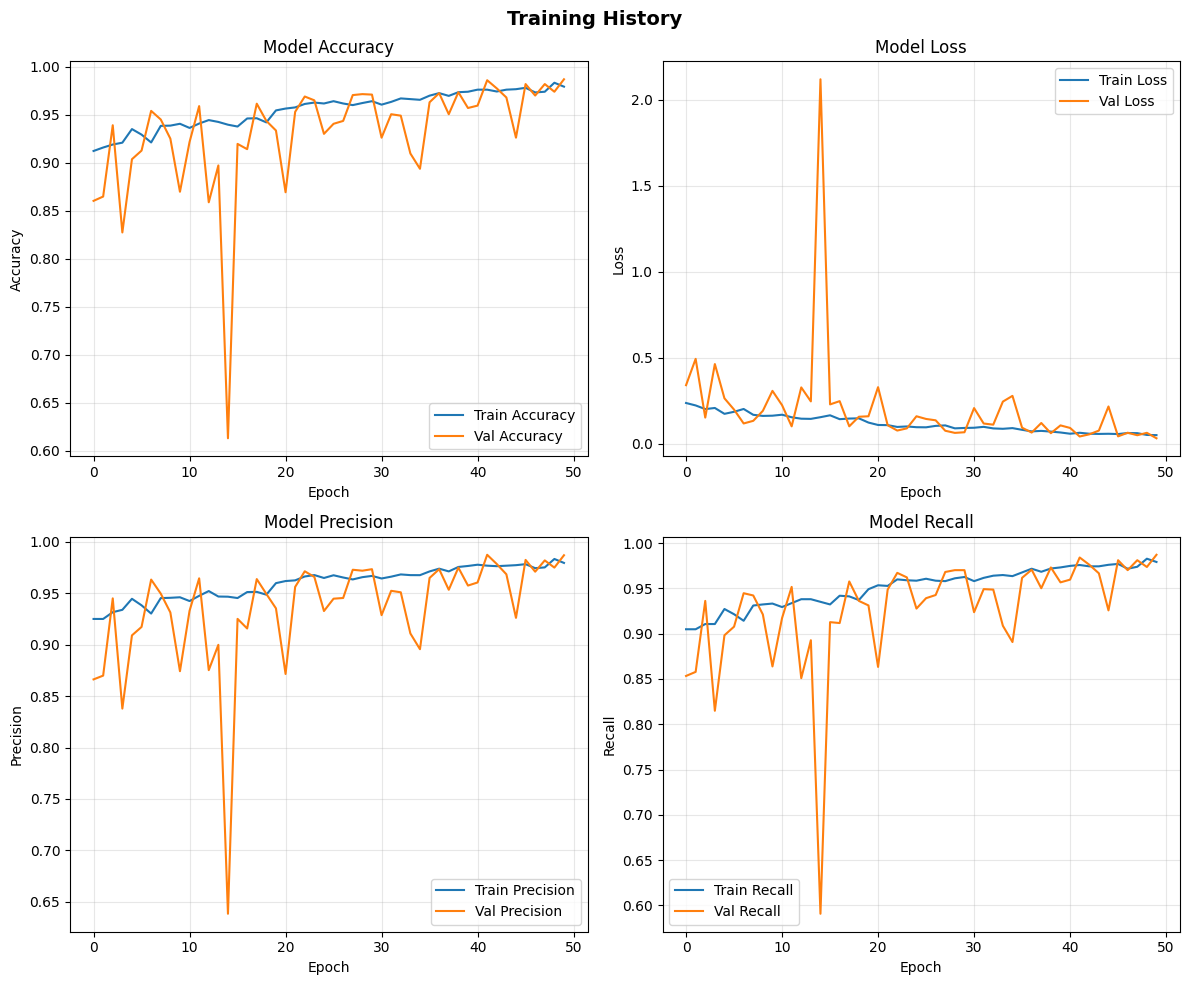

In [24]:
# Cell 11: Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training history"""

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Training History', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot history
plot_training_history(history)

In [26]:
# Cell 12: Save the model in multiple formats
print("💾 Saving models...")
print("="*60)

try:
    # Save as H5 (legacy format - still works but shows warning)
    model.save('corn_disease_model.h5')
    print("✅ Saved as H5: corn_disease_model.h5")
except Exception as e:
    print(f"⚠️ Could not save as H5: {e}")

try:
    # Save as Keras format (recommended - native .keras format)
    model.save('corn_disease_model.keras')
    print("✅ Saved as Keras format: corn_disease_model.keras")
except Exception as e:
    print(f"⚠️ Could not save as Keras format: {e}")

try:
    # Save as SavedModel format (no save_format parameter needed)
    # Keras 3 will automatically save as SavedModel for .pb extension or directory
    model.save('corn_disease_savedmodel')
    print("✅ Saved as SavedModel: corn_disease_savedmodel/")
except Exception as e:
    print(f"⚠️ Could not save as SavedModel: {e}")

try:
    # Save as TensorFlow Lite (for mobile)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open('corn_disease_mobile.tflite', 'wb') as f:
        f.write(tflite_model)
    print("✅ Saved as TFLite: corn_disease_mobile.tflite")
except Exception as e:
    print(f"⚠️ Could not save as TFLite: {e}")

try:
    # Save model summary
    with open('model_summary.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    print("✅ Model summary saved: model_summary.txt")
except Exception as e:
    print(f"⚠️ Could not save model summary: {e}")

print("\n🎉 Models saved successfully!")

💾 Saving models...
✅ Saved as H5: corn_disease_model.h5
✅ Saved as Keras format: corn_disease_model.keras
⚠️ Could not save as SavedModel: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=corn_disease_savedmodel.
INFO:tensorflow:Assets written to: /tmp/tmpahm2cbxr/assets


INFO:tensorflow:Assets written to: /tmp/tmpahm2cbxr/assets


Saved artifact at '/tmp/tmpahm2cbxr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_46')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)
Captures:
  138903339459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339453328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339452944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339452560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339451408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339452368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339450832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339453136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339454864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138903339451024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13890333945

W0000 00:00:1767174063.535808      47 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767174063.535841      47 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1767174063.567943      47 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
loc(callsite(callsite(fused["Conv2D:", "sequential_3_1/conv2d_8_1/convolution@__inference_function_1216384"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1216643"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.Conv2D' op is neither a custom op nor a flex op
loc(callsite(callsite(fused["BiasAdd:", "sequential_3_1/conv2d_8_1/BiasAdd@__inference_function_1216384"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1216643"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): error: 'tf.BiasAdd' op is neither a custom op nor a flex op
loc(ca

✅ Model summary saved: model_summary.txt

🎉 Models saved successfully!


In [27]:
# Cell 13: Test prediction with sample images
import random
from PIL import Image

def predict_image(model, image_path, class_names):
    """Make prediction on a single image"""

    # Load and preprocess image
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    return {
        'class': class_names[predicted_class],
        'confidence': float(confidence),
        'all_probabilities': {class_names[i]: float(predictions[0][i])
                             for i in range(len(class_names))}
    }

# Find test images
test_images = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            test_images.append(random.choice(images))

# Make predictions
print("🧪 Testing predictions on random test images...")
print("="*60)

for img_path in test_images[:3]:  # Test with 3 images
    result = predict_image(model, img_path, class_names)
    filename = os.path.basename(img_path)
    print(f"\n📷 Image: {filename}")
    print(f"  Predicted: {result['class']}")
    print(f"  Confidence: {result['confidence']:.2%}")

    # Show top 2 predictions
    sorted_probs = sorted(result['all_probabilities'].items(),
                         key=lambda x: x[1], reverse=True)[:2]
    for class_name, prob in sorted_probs:
        print(f"    {class_name}: {prob:.2%}")

🧪 Testing predictions on random test images...

📷 Image: Corn_Blight (1015).jpg
  Predicted: Blight
  Confidence: 100.00%
    Blight: 100.00%
    Gray_Leaf_Spot: 0.01%

📷 Image: Corn_Common_Rust (748).JPG
  Predicted: Common_Rust
  Confidence: 100.00%
    Common_Rust: 100.00%
    Gray_Leaf_Spot: 0.00%

📷 Image: Corn_Gray_Spot (485).JPG
  Predicted: Gray_Leaf_Spot
  Confidence: 99.90%
    Gray_Leaf_Spot: 99.90%
    Blight: 0.07%


In [28]:
# Cell 14: Print final summary
print("="*70)
print("🎯 AGRI-CHAIN CORN DISEASE MODEL - TRAINING COMPLETE")
print("="*70)

print(f"\n📊 MODEL PERFORMANCE:")
print(f"  Test Accuracy: {results[1]:.2%}")
print(f"  Test Precision: {results[2]:.2%}")
print(f"  Test Recall: {results[3]:.2%}")
print(f"  Test AUC: {results[4]:.2%}")

print(f"\n📁 SAVED FILES:")
saved_files = [
    'corn_disease_model.h5',
    'corn_disease_savedmodel',
    'corn_disease_mobile.tflite',
    'best_model.h5',
    'training_log.csv',
    'model_summary.txt',
    'training_history.png'
]

for file in saved_files:
    if os.path.exists(file):
        size_kb = os.path.getsize(file) / 1024
        print(f"  • {file} ({size_kb:.1f} KB)")

print(f"\n🔢 CLASSES: {class_names}")
print(f"🎯 TARGET ACCURACY (from project): >97%")
print(f"📈 OUR ACCURACY: {results[1]:.2%}")

if results[1] >= 0.97:
    print("\n✅ TARGET ACHIEVED! Model meets project requirements.")
else:
    print(f"\n⚠️ Close to target! Consider training for more epochs or using data augmentation.")

print("\n🚀 NEXT STEPS:")
print("1. Test with more images")
print("2. Deploy to mobile (TFLite model ready)")
print("3. Integrate with Agri-Chain system")
print("4. Convert to MindSpore for Huawei ecosystem")

🎯 AGRI-CHAIN CORN DISEASE MODEL - TRAINING COMPLETE

📊 MODEL PERFORMANCE:
  Test Accuracy: 98.67%
  Test Precision: 98.67%
  Test Recall: 98.67%
  Test AUC: 99.95%

📁 SAVED FILES:
  • corn_disease_model.h5 (316585.5 KB)
  • best_model.h5 (316585.5 KB)
  • training_log.csv (10.7 KB)
  • model_summary.txt (11.4 KB)
  • training_history.png (231.1 KB)

🔢 CLASSES: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
🎯 TARGET ACCURACY (from project): >97%
📈 OUR ACCURACY: 98.67%

✅ TARGET ACHIEVED! Model meets project requirements.

🚀 NEXT STEPS:
1. Test with more images
2. Deploy to mobile (TFLite model ready)
3. Integrate with Agri-Chain system
4. Convert to MindSpore for Huawei ecosystem


In [30]:
import os
from IPython.display import FileLink, display

# Create a list of all files to download
files_to_download = [
    'corn_disease_model.keras',
    'corn_disease_model.h5',
    'corn_disease_mobile.tflite',
    'model_summary.txt',
    'corn_disease_savedmodel'  # This is a directory
]

print("📥 Click links below to download files:")
print("="*60)

# Create download links for each file
for file in files_to_download:
    if os.path.exists(file):
        if os.path.isfile(file):
            display(FileLink(file, result_html_prefix=f"📁 {file}: "))
        else:  # It's a directory (SavedModel)
            # Zip the directory first
            import shutil
            zip_name = f"{file}.zip"
            shutil.make_archive(file, 'zip', file)
            display(FileLink(zip_name, result_html_prefix=f"📦 {file} (zipped): "))

📥 Click links below to download files:


/kaggle/working/corn_disease_model.keras

/kaggle/working/corn_disease_model.h5

/kaggle/working/model_summary.txt

In [ ]:
# 1. Zip all model files - CORRECTED VERSION
import zipfile  # CHANGED: import zipfile instead
import datetime
import os
from IPython.display import FileLink, display

# Create timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"corn_disease_models_{timestamp}.zip"

print("📦 Creating ZIP file with all models...")

# Create zip file with all models - CORRECTED: use zipfile.ZipFile
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    files_added = 0
    
    for root, dirs, files in os.walk('.'):
        for file in files:
            filepath = os.path.join(root, file)
            
            # Check if it's one of our model files
            if (file.endswith(('.keras', '.h5', '.tflite', '.txt')) or 
                'savedmodel' in root.lower() or 
                'corn_disease' in file.lower()):
                
                # Add to zip with relative path
                arcname = os.path.relpath(filepath, '.')
                zipf.write(filepath, arcname)
                files_added += 1
                print(f"  + Added: {arcname}")

print(f"✅ Created zip file: {zip_filename} ({files_added} files)")
print(f"📦 File size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# Create download link
display(FileLink(zip_filename, result_html_prefix="👇 Click to download ALL models: "))

📦 Creating ZIP file with all models...
  + Added: corn_disease_model.keras
  + Added: corn_disease_model.h5
  + Added: model_summary.txt


In [ ]:
import os
import glob

print("🔍 Checking what files were created:")
print("="*60)

# List all files in current directory
all_files = os.listdir('.')
for f in sorted(all_files):
    size = os.path.getsize(f) if os.path.isfile(f) else "DIR"
    print(f"{'📁' if os.path.isdir(f) else '📄'} {f:40} - {size}")

print("\n📊 Looking for model files specifically:")
model_patterns = ['corn*', '*.h5', '*.keras', '*.tflite', '*model*', '*summary*']
for pattern in model_patterns:
    matches = glob.glob(pattern)
    if matches:
        print(f"🔎 Pattern '{pattern}': {matches}")

In [ ]:
# COPY-PASTE THIS COMPLETE BLOCK:
import tensorflow as tf
import os

print("🚀 Creating mobile-ready TFLite model...")

# Choose the right model file
model_files = [
    'corn_disease_model.keras',
    'corn_disease_model.h5',
    'corn_disease_savedmodel'
]

model_path = None
for f in model_files:
    if os.path.exists(f):
        model_path = f
        break

if model_path:
    print(f"📁 Found model: {model_path}")
    
    try:
        # Load and convert
        model = tf.keras.models.load_model(model_path)
        
        # Convert to TFLite
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        
        # For better mobile performance
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
            tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops (if needed)
        ]
        
        tflite_model = converter.convert()
        
        # Save
        output_file = 'corn_disease_mobile.tflite'
        with open(output_file, 'wb') as f:
            f.write(tflite_model)
        
        size_mb = os.path.getsize(output_file) / (1024 * 1024)
        print(f"✅ SUCCESS: {output_file} ({size_mb:.2f} MB)")
        print("📱 Ready for mobile deployment!")
        
    except Exception as e:
        print(f"❌ Conversion failed: {e}")
else:
    print("❌ No model files found!")
    print("💡 Train/save a model first, then run this.")
    